This is a new version, summarize what we have and move on. 

In [1]:
# Run this will automatically install all required packages
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import os, sys, scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss, accuracy_score, f1_score     # evaluation metrics with accuracy_score that automatically compares results
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
import sklearn.tree as tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression 

from sklearn.ensemble import RandomForestClassifier


In [3]:
def load_svhn_data(data_dir='../data/raw', split='train'):      # '../data/raw' is where I put my data files. Change it to yours
    """
    Loads SVHN cropped digit data from .mat files.
    
    Args:
        data_dir (str): Path to the folder containing .mat files.
        split (str): 'train' or 'test'.
        
    Returns:
        X (np.array): Images of shape (N, 32, 32, 3) -> Normalized [0, 1]
        y (np.array): Labels of shape (N,) -> Corrected so '0' is class 0 (not 10)
    """
    file_path = os.path.join(data_dir, f'{split}_32x32.mat')
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}. Please download it from http://ufldl.stanford.edu/housenumbers/")

    print(f"Loading {split} data from {file_path}...")
    mat_data = scipy.io.loadmat(file_path)
    
    # The .mat file has X shape: (32, 32, 3, N) -> (Height, Width, Channels, Batch)
    # We want standard shape: (N, 32, 32, 3) for visualization/processing
    X = mat_data['X']
    X = np.transpose(X, (3, 0, 1, 2))
    
    # Normalize pixel values to [0, 1] range (Standard for Deep Learning)
    X = X.astype('float32') / 255.0

    # The .mat file has y shape: (N, 1). Flatten it to (N,)
    y = mat_data['y'].flatten()
    
    # FIX LABELS: SVHN labels '0' as 10. We need to map 10 -> 0.
    y[y == 10] = 0
    
    print(f"Loaded {X.shape[0]} samples.")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y

In [4]:
X_train, y_train = load_svhn_data()

Loading train data from ../data/raw/train_32x32.mat...
Loaded 73257 samples.
X shape: (73257, 32, 32, 3)
y shape: (73257,)


DATA EXPLOREATION

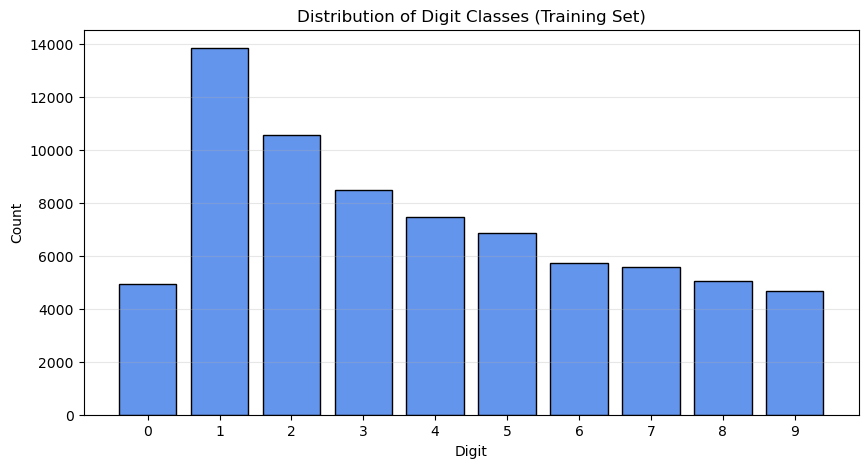

Most common: 1 (Count: 13861)
Least common: 9 (Count: 4659)


In [5]:
# --- Plot 1: Class Distribution (Imbalance Check) ---
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='cornflowerblue', edgecolor='black')
plt.title('Distribution of Digit Classes (Training Set)')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Insight: Print imbalance ratio
print(f"Most common: {unique[np.argmax(counts)]} (Count: {max(counts)})")
print(f"Least common: {unique[np.argmin(counts)]} (Count: {min(counts)})")

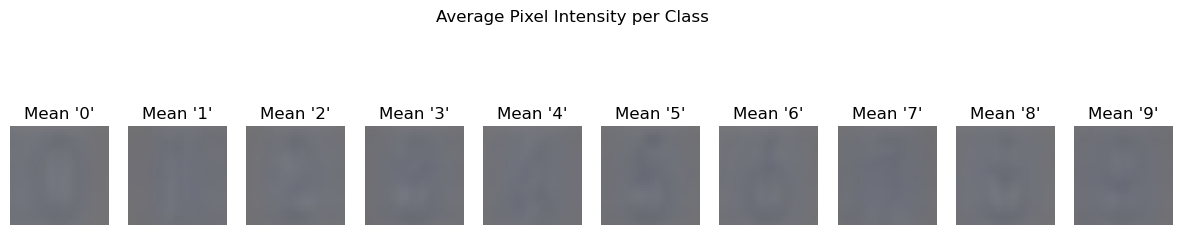

In [6]:
# --- Plot 2: The \"Mean\" Digit (Data Quality/Alignment) ---
plt.figure(figsize=(15, 3))
for i in range(10):
    idxs = np.where(y_train == i)[0]
    mean_img = np.mean(X_train[idxs], axis=0) # Average pixel intensity
    plt.subplot(1, 10, i+1)
    plt.imshow(mean_img)
    plt.title(f"Mean '{i}'")
    plt.axis('off')
plt.suptitle('Average Pixel Intensity per Class', y=1.05)
plt.show()

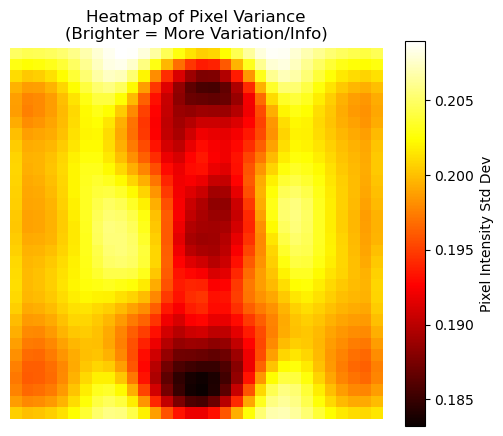

In [7]:
# --- Plot 3: Pixel Standard Deviation Heatmap ---
# Calculate the standard deviation of pixel intensity across all images
std_img = np.std(X_train, axis=0) # Shape: (32, 32, 3)
# Average across color channels to get a single heatmap
std_heatmap = np.mean(std_img, axis=2)

plt.figure(figsize=(6, 5))
plt.imshow(std_heatmap, cmap='hot', interpolation='nearest')
plt.colorbar(label='Pixel Intensity Std Dev')
plt.title('Heatmap of Pixel Variance\n(Brighter = More Variation/Info)')
plt.axis('off')
plt.show()

Running T-SNE... (this might take a moment)


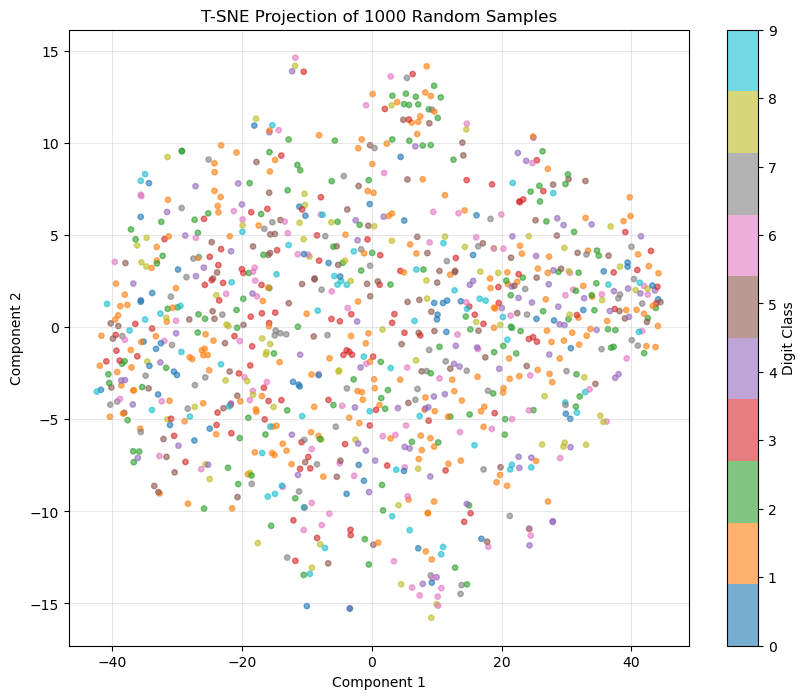

In [8]:
from sklearn.manifold import TSNE

# --- Plot 4: T-SNE 2D Projection ---
# Select a subset for speed
subset_indices = np.random.choice(len(X_train), 1000, replace=False)
X_flat = X_train.reshape(X_train.shape[0], -1)
X_subset = X_flat[subset_indices]
y_subset = y_train[subset_indices]

print("Running T-SNE... (this might take a moment)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_subset)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_subset, cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, label='Digit Class', ticks=range(10))
plt.title('T-SNE Projection of 1000 Random Samples')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, alpha=0.3)
plt.show()

We have tried 3 Methods as our three models:

1. Logistic Regression           # Flattens & destroys the 32 * 32 image corrolation 
2. Multi-Layer Percptron        
3. Random Forrest               



In [9]:
seed = 1234
np.random.seed(seed)        

In [10]:
# 1. Baseline: Logistic Regression
print("Training Logistic Regression...")
log_reg = LogisticRegression(random_state = seed, C = 0.01, max_iter=100, multi_class='multinomial')
log_reg.fit(X_flat, y_train)
y_pred_log = log_reg.predict(X_flat)
print(f"Logistic Regression Accuracy: {accuracy_score(y_train, y_pred_log):.4f}")

Training Logistic Regression...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.2724


In [11]:
# 2. Random Forest (Ensemble Method)
print("Training Random Forest...")
rf = RandomForestClassifier(criterion = 'entropy', n_estimators=100, max_depth=50, min_samples_leaf = 2, n_jobs=-1, random_state=seed)
rf.fit(X_flat, y_train)
y_pred_rf = rf.predict(X_flat)
print(f"Random Forest Accuracy: {accuracy_score(y_train, y_pred_rf):.4f}")

Training Random Forest...
Random Forest Accuracy: 0.9999


In [12]:
# 3. MLP (Simple Neural Network)
print("Training MLP...")
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=50, activation='relu', solver='sgd', random_state = seed, batch_size=256)
mlp.fit(X_flat, y_train)
y_pred_mlp = mlp.predict(X_flat)
print(f"MLP Accuracy: {accuracy_score(y_train, y_pred_mlp):.4f}")

Training MLP...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 0.7618


The CNN

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from dl_model import SVHN_CNN

In [15]:
# 1. Prepare Data
# Convert numpy arrays to PyTorch tensors (N, C, H, W)
tensor_x = torch.Tensor(X_train).permute(0, 3, 1, 2) # Change to (N, 3, 32, 32)
tensor_y = torch.Tensor(y_train).long()

dataset = TensorDataset(tensor_x, tensor_y)

In [16]:
# 80/20 Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [17]:
# 3. Setup Model & Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SVHN_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [22]:
num_epochs = 10
train_losses = []
val_errors = []

print(f"Starting training on {device}...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate Average Training Loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    val_error = 100 - val_acc  # Convert Accuracy to Error Rate
    val_errors.append(val_error)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Error: {val_error:.2f}%")

Starting training on cpu...
Epoch 1/10 | Train Loss: 0.2441 | Val Error: 10.79%
Epoch 2/10 | Train Loss: 0.2298 | Val Error: 9.73%
Epoch 3/10 | Train Loss: 0.2170 | Val Error: 9.90%
Epoch 4/10 | Train Loss: 0.2058 | Val Error: 9.68%
Epoch 5/10 | Train Loss: 0.1978 | Val Error: 9.75%
Epoch 6/10 | Train Loss: 0.1875 | Val Error: 9.38%
Epoch 7/10 | Train Loss: 0.1819 | Val Error: 9.46%
Epoch 8/10 | Train Loss: 0.1685 | Val Error: 9.35%
Epoch 9/10 | Train Loss: 0.1661 | Val Error: 9.53%
Epoch 10/10 | Train Loss: 0.1547 | Val Error: 9.34%


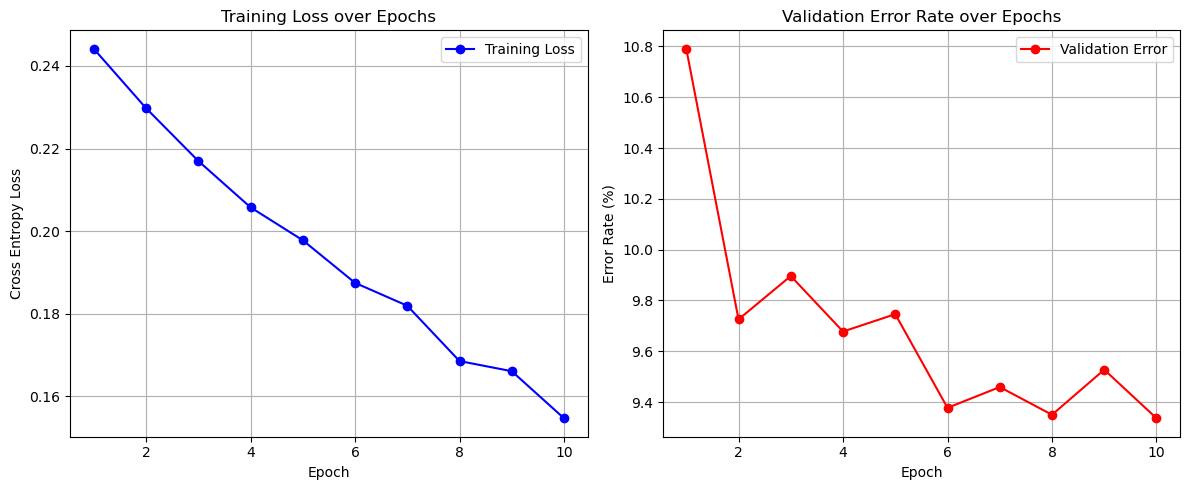

In [23]:
# --- 5. Plotting the Results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True)
plt.legend()

# Plot 2: Validation Error
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_errors, 'r-o', label='Validation Error')
plt.title('Validation Error Rate over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()